# Notebook to create train & test set of images

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
sys.path.append('scripts/')
import numpy as np
import matplotlib.pyplot as plt
import rasterio, rasterio.plot
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv


path_dict = loadpaths.loadpaths()

## Create shape file of list of tile names

In [4]:
## Get list of tile names from text file:
with open('/home/tplas/repos/cnn-land-cover/content/tiles_few_changes/tiles_few_changes_list.txt', 'r') as f:
    tiles_unchanged = f.readlines()
tiles_unchanged = [x.rstrip('\n') for x in tiles_unchanged]

In [5]:
## Select tiles by name & save as new shp file
tmp = lca.select_tiles_from_list(list_tile_names=tiles_unchanged, 
                                 save_new_shp=False,
                                 new_shp_filename='content/tiles_few_changes/tiles_few_changes')

## Get distribution of classes of tiles from shp

In [6]:
## LC polygons:
df_lc_80s, mapping_class_inds = lca.load_landcover(pol_path=os.path.join(path_dict['lc_80s_path']))

Text(0.5, 1.0, 'Distribution of LC of entire PD')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


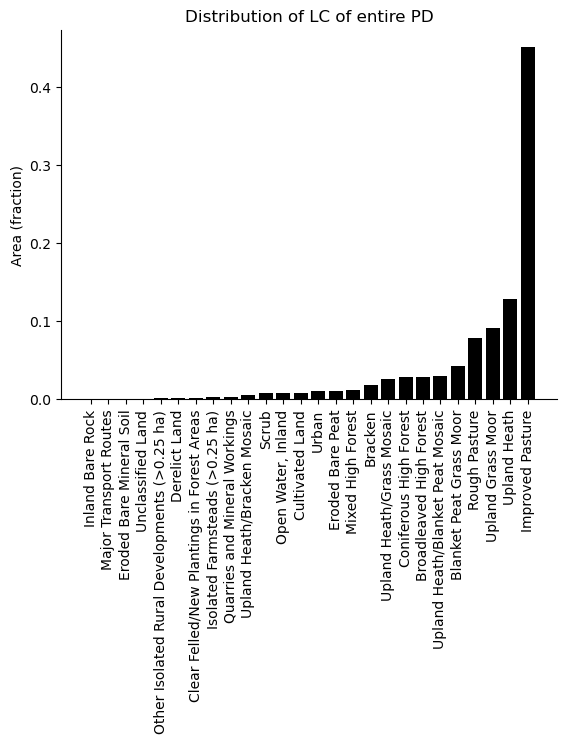

In [7]:
ax_distr, _ = lcv.plot_distr_classes_from_shape(df_lc=df_lc_80s)
ax_distr.set_title('Distribution of LC of entire PD')

In [8]:
## Instead, we can use the existing shp file:
df_all_tiles = lca.get_shp_all_tiles()
# df_all_tiles = df_all_tiles.iloc[np.random.choice(a=2125, size=100, replace=False)]

In [9]:
## Get LC polygons for each tile, for all tiles:
dict_intersect_pols_all_tiles = lca.get_pols_for_tiles(df_pols=df_lc_80s, df_tiles=df_all_tiles, col_name='PLAN_NO')

100%|██████████| 2125/2125 [02:07<00:00, 16.63it/s]


In [10]:
## Calculate distribution of classes for each tile:
df_class_distr = lca.create_df_with_class_distr_per_tile(dict_dfs=dict_intersect_pols_all_tiles, 
                                                         all_class_names=list(df_lc_80s['LC_D_80'].unique()),
                                                         no_class_threshold=0.05)
df_all_tiles = df_all_tiles[np.isin(df_all_tiles['PLAN_NO'], df_class_distr['tile_name'])]
assert len(df_all_tiles) == len(df_class_distr)

2125it [00:05, 411.82it/s]

2125 tiles analysed
777 tiles kept after no-class filter


In [11]:
inds_tiles, df_lc_sample = lca.sample_tiles_by_class_distr_from_df(df_all_tiles_distr=df_class_distr, 
                                              n_samples=50, iterations=20000)

At it 2 new loss of 0.1009482056443721
At it 41 new loss of 0.09641860801009422
At it 163 new loss of 0.09395308956905257
At it 204 new loss of 0.09061626432174559
At it 300 new loss of 0.08322722908529512
At it 753 new loss of 0.07263979163358138
At it 2268 new loss of 0.06208913290461872


(1e-06, 0.3)

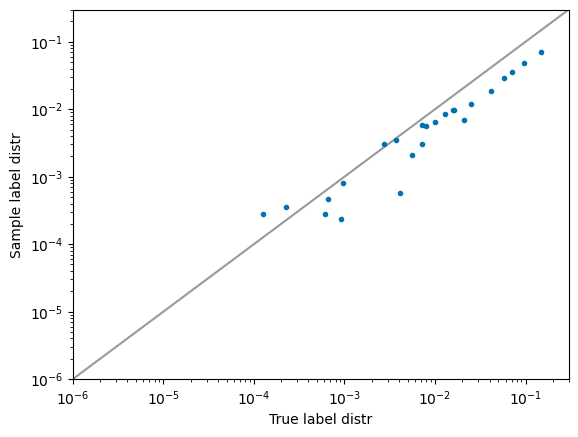

In [12]:
plt.plot([1e-6, 1], [1e-6, 1], c='k', alpha=0.4)
plt.plot(df_class_distr.sum(0, numeric_only=True) / len(df_class_distr), df_lc_sample.sum(0, numeric_only=True) / 100, '.')

plt.xlabel('True label distr')
plt.ylabel('Sample label distr')
plt.yscale('log')
plt.xscale('log')
plt.xlim([1e-6, 3e-1])
plt.ylim([1e-6, 3e-1])

In [15]:
df_all_tiles.iloc[inds_tiles].to_file('content/sample_50tiles/sample_50tiles_distr.shp')

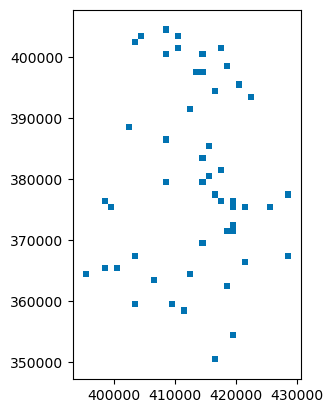

In [16]:
df_all_tiles.iloc[inds_tiles].plot()

## Compare AREA column vs area calculation of polygon:

In [ ]:
# np.isclose(df_lc_80s['AREA'], df_lc_80s['geometry'].area).sum()
# 
plt.plot(df_lc_80s['AREA'], df_lc_80s['geometry'].area, '.')
plt.xlabel('Reported Area')
plt.ylabel('Polygon area')
print(np.where(np.abs(df_lc_80s['AREA'] - df_lc_80s['geometry'].area) > 1e4)[0])

In [ ]:
# i_pol = 37
# print(df_lc_80s.iloc[i_pol])
for i_pol in np.where(np.abs(df_lc_80s['AREA'] - df_lc_80s['geometry'].area) > 1e2)[0]:
    print(i_pol, df_lc_80s.iloc[i_pol]['LC_D_80'])
    print(f'Area of pol is {df_lc_80s.iloc[i_pol]["geometry"].area / 1e6} km^2, but DF says {df_lc_80s.iloc[i_pol]["AREA"] / 1e6}')


In [ ]:
df_lc_80s['AREA'].max() / 1e6

In [ ]:
print(f'Total area according to DF is {df_lc_80s["AREA"].sum() / 1e6} km^2 but according to pol {df_lc_80s["geometry"].area.sum() / 1e6} km^2')

In [ ]:
ax_distr, _ = lcv.plot_distr_classes_from_shape(df_lc=df_lc_80s)
ax_distr.set_title('Distribution of LC of entire PD')